---
# 1) Resumo

Neste notebook foram feitos os treinamentos e seleção de hyperparamentros de 6 modelos de **ML** distintos. Os modelos estudados foram:

* DummyClassifier
* LogisticRegression
* DecisionTreeClassifier
* Forest Tree
* Support Vector Machine
* KNeighbors

A busca pelos hyperparametros foram feitas pelo GridSearchCV ou pelo RandomizedSearchCV. Para a Cross Validation foi usado **RepeatedStratifiedKFold** com **5** divições de **10** repetições.

O parametro utilizado para avaliação do modelo foi **ROC_AUC** e quantidade de **falsos negativos** (FN).

A base de dados utilizados tem **351** amostras com **52** variaveis explicativas. Dessas **351** amostras **298** foram usados para **Cross Validation** (treino + teste) e **53** foram usados para a **validação**.


---
# 2) Pre-analise

---
## 2.1) Minhas Funções

In [23]:
collab=False #Notebook roda no collab ?  

if (collab):
  !pip install matplotlib==3.4.2
  !wget "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/plota_graficos.py"
  !wget "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/ml.py"
  !wget "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/info.py"

  from plota_graficos import plota_treino_teste_auc, plota_curva_roc, plota_matriz_de_confusao
  from ml import retorna_x_y, intervalo_de_confianca, treina_modelo_grid_search_cv,\
                 treina_modelo_randomized_search_cv, obtem_os_resultados_SearchCV, cv_val_split, desempenho_dos_modelos

  from info import proporcao_y, porcentagem_teste_treino_val, resultados_treinamento, dimensao_dados

else:
  import sys
  sys.path.insert(1, "../../")

  from src.plota_graficos import plota_treino_teste_auc, plota_curva_roc, plota_matriz_de_confusao
  from src.ml import retorna_x_y, intervalo_de_confianca, treina_modelo_grid_search_cv,\
                   treina_modelo_randomized_search_cv, obtem_os_resultados_SearchCV, cv_val_split, desempenho_dos_modelos 

  from src.info import proporcao_y, numero_teste_treino_val, resultados_treinamento, dimensao_dados

---
## 2.2) Importando libs

In [24]:
import pandas as pd
#
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#
import matplotlib.pyplot as plt
#
import numpy as np
#
from scipy.stats import uniform

---
# 3) Lendo os dados

In [113]:
path = "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/Dados/Tratados/dados_sem_coor_acima_do_valor_de_corte.csv"

dados_com_corte = pd.read_csv(path)

dimensao_dados(dados_com_corte)

dados_com_corte.tail(n=5)

Numero de linhas : 351 
Numero de colunas: 181 


,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,ICU
346,0,-0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.357143,0.472527,0.898990,-0.418803,-0.783784,0.059701,-0.515152,-0.072464,0.736842,1
347,1,1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.357143,0.230769,0.818182,-0.589744,-0.783784,-0.432836,-0.515152,0.072464,0.526316,0
348,0,-0.111111,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.357143,0.340659,0.959596,-0.299145,-0.567568,-0.462687,-0.515152,-0.246377,0.894737,1
349,0,-0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.571429,0.318681,0.898990,-0.247863,-0.459459,-0.447761,-0.696970,-0.275362,0.736842,0
350,0,-0.111111,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.428571,0.714286,0.919192,-0.299145,-0.502703,-0.164179,-0.575758,0.246377,0.789474,0


In [114]:
dados_com_corte.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 0 to 350
Columns: 181 entries, AGE_ABOVE65 to ICU
dtypes: float64(178), int64(3)
memory usage: 499.1 KB


In [115]:
dados_com_corte.describe()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,ICU
count,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,...,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.458689,-0.046534,0.381766,0.108262,0.022792,0.091168,0.019943,0.128205,0.045584,0.196581,...,-0.398453,0.424439,0.898760,-0.313074,-0.498237,-0.376494,-0.497712,-0.079153,0.780627,0.461538
std,0.499002,0.640366,0.486513,0.311155,0.149453,0.288259,0.140004,0.334795,0.208879,0.397980,...,0.229894,0.172654,0.049813,0.185592,0.205730,0.234854,0.215762,0.235868,0.121561,0.499230
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-0.010989,0.717172,-0.760684,-0.891892,-0.850746,-0.939394,-0.652174,0.263158,0.000000
25%,0.000000,-0.555556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.500000,0.318681,0.878788,-0.418803,-0.664865,-0.537313,-0.636364,-0.275362,0.684211,0.000000
50%,0.000000,-0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.428571,0.406593,0.898990,-0.299145,-0.513514,-0.417910,-0.575758,-0.101449,0.789474,0.000000
75%,1.000000,0.555556,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.357143,0.538462,0.939394,-0.213675,-0.351351,-0.268657,-0.454545,0.043478,0.842105,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.978022,1.000000,0.487179,0.200000,0.716418,0.636364,0.768116,1.000000,1.000000


### Divindido os dados em validação e Cross Valadiation (teste+treino)

In [116]:
x_cv, x_val, y_cv, y_val = cv_val_split(dados_com_corte, p_val = .15)

### Verificando se a proporção foi mantida 

In [117]:
proporcao_y(dados_com_corte['ICU'])
proporcao_y(y_val)
proporcao_y(y_cv )

Proporcao do ICU
Campo 0 ->  53.85%
Campo 1 ->  46.15%
Proporcao do ICU
Campo 0 ->  54.72%
Campo 1 ->  45.28%
Proporcao do ICU
Campo 0 ->  53.69%
Campo 1 ->  46.31%


In [118]:
numero_teste_treino_val(dados_com_corte['ICU'], y_val, y_cv)

Número total de entradas                         : 351
Número total de entradas para validacao          : 53
Número total de entradas para o Cross Validation : 298


# 4) Modelo de ML

A opção **refit** foi deixado como **true** logo depois que o melhor modelo for selecioando o RandomizedSearchCV/GridSearchCv **re-treina** esse modelo com o dataset completo (treino+teste). 

In [119]:
n_iter   = 20
n_splits = 5
n_repeats= 10

## 4.1) DummyClassifier

> Aqui será treinado do modelo **DummyClassifier**. Para o treino foi usado **GridSearchCV**. O único hyperparametro disponivel foi **strategy**. O intervalor de busca  **[stratified, 'ost_frequent, prior, 'uniform]**. O DummyClassifier será usado como o nosso modelo **"baseline"**



In [120]:
modelo = DummyClassifier(random_state=141715)

parameters = {'strategy' : ['stratified', 'most_frequent', 'prior', 'uniform']}

resultados, melhor_modelo_dummy, melhores_hyperparametros  = treina_modelo_grid_search_cv(modelo,
                                                                                      x_cv,
                                                                                      y_cv,
                                                                                      parameters,
                                                                                      n_splits=n_splits,
                                                                                      n_repeats=n_repeats,
                                                                                      seed=14715)

resultados_treinamento(resultados, melhor_modelo_dummy, melhores_hyperparametros)

Fitting 50 folds for each of 4 candidates, totalling 200 fits
melhores hyperparametros : {'strategy': 'most_frequent'}
Melhor modelo            : DummyClassifier(random_state=141715, strategy='most_frequent')


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,{'strategy': 'stratified'},0.490914,0.484953,0.057227,0.032434,0.001899,0.000754,0.002718,0.000601,4
1,{'strategy': 'most_frequent'},0.500000,0.500000,0.000000,0.000000,0.001859,0.000347,0.002339,0.000474,1
2,{'strategy': 'prior'},0.500000,0.500000,0.000000,0.000000,0.001779,0.000414,0.002398,0.000490,1
3,{'strategy': 'uniform'},0.500000,0.500000,0.000000,0.000000,0.001679,0.000466,0.002518,0.000499,1


---
## 4.2) Regreção logistica

> Aqui será treinado do modelo **LogisticRegression**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros foram:
>* C             : [0, 4]


Fitting 50 folds for each of 50 candidates, totalling 2500 fits


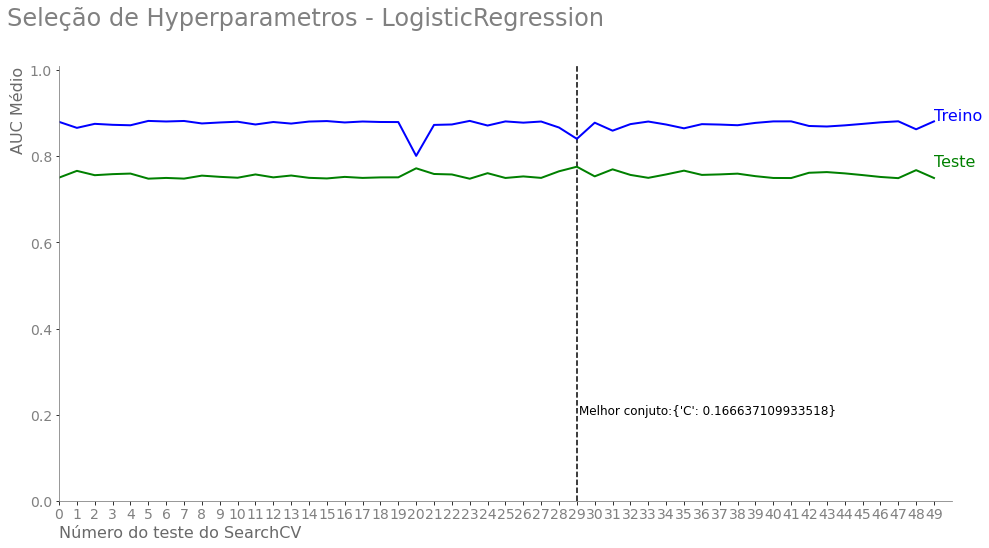

melhores hyperparametros : {'C': 0.166637109933518}
Melhor modelo            : LogisticRegression(C=0.166637109933518, max_iter=1000, tol=1e-06)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,{'C': 2.9403726439047437},0.750552,0.880109,0.057537,0.012550,0.137316,0.022139,0.007315,0.000545,35
1,{'C': 0.8236321513787566},0.766271,0.866133,0.052538,0.011980,0.082170,0.009936,0.007375,0.000596,6
2,{'C': 1.8107081253404766},0.756222,0.875497,0.055397,0.012294,0.117108,0.012728,0.007575,0.000635,23
3,{'C': 1.4507591152545065},0.758666,0.873221,0.054106,0.012179,0.104956,0.012537,0.007375,0.000525,15
4,{'C': 1.3163817298661398},0.759973,0.872162,0.053748,0.012131,0.095302,0.009652,0.007135,0.000347,12
5,{'C': 3.7627108804741063},0.748153,0.882259,0.057566,0.012598,0.257651,0.107490,0.010753,0.005546,49
6,{'C': 3.2348466053974367},0.749849,0.880957,0.057910,0.012576,0.191110,0.064378,0.009170,0.002628,41
7,{'C': 3.6987640689695644},0.748267,0.882140,0.057530,0.012618,0.170633,0.028053,0.008229,0.001543,48
8,{'C': 1.9704679412547428},0.755215,0.876383,0.055832,0.012357,0.133678,0.034524,0.007938,0.000820,25
9,{'C': 2.4854242092996466},0.752405,0.878636,0.056914,0.012534,0.140845,0.021027,0.008131,0.001267,29


In [121]:
parameters = {'C': uniform(loc=0, scale=4)}
modelo = LogisticRegression(max_iter=1000, tol=1e-6)

resultados, melhor_modelo_lr, melhores_hyperparametros  = treina_modelo_randomized_search_cv(modelo,
                                                                                            x_cv,
                                                                                            y_cv,
                                                                                            parameters,
                                                                                            n_splits=n_splits,
                                                                                            n_repeats=n_repeats,
                                                                                            n_iter=n_iter,
                                                                                            seed=14715)

plota_treino_teste_auc('Seleção de Hyperparametros - LogisticRegression', 
                       resultados['media_teste'],
                       resultados['media_treino'],
                       resultados['rank_test_score'],
                       melhores_hyperparametros)

resultados_treinamento(resultados, melhor_modelo_lr, melhores_hyperparametros, n = 10)

---
## 4.3) Arvore de decissão

> Aqui será treinado do modelo **DecisionTreeClassifier**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros foram:
>* max_depth       : [1-20]
>* criterion       : [gini, entropy]
>* min_samples_leaf: [1-5]
>* max_leaf_nodes  : [2-5]


Fitting 50 folds for each of 10 candidates, totalling 500 fits


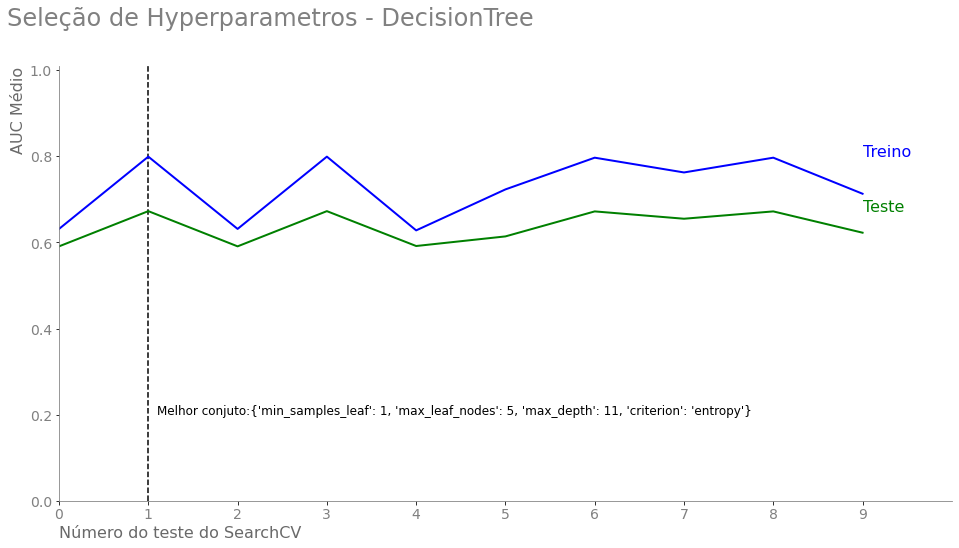

melhores hyperparametros : {'min_samples_leaf': 1, 'max_leaf_nodes': 5, 'max_depth': 11, 'criterion': 'entropy'}
Melhor modelo            : DecisionTreeClassifier(criterion='entropy', max_depth=11, max_leaf_nodes=5)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'min_samples_leaf': 5, 'max_leaf_nodes': 2, '...",0.590954,0.631444,0.050327,0.016861,0.008090,0.002061,0.007368,0.002416,9
1,"{'min_samples_leaf': 1, 'max_leaf_nodes': 5, '...",0.672723,0.799308,0.077351,0.014636,0.009961,0.000721,0.006076,0.000868,1
2,"{'min_samples_leaf': 5, 'max_leaf_nodes': 2, '...",0.590954,0.631444,0.050327,0.016861,0.006795,0.000748,0.005957,0.000773,9
3,"{'min_samples_leaf': 4, 'max_leaf_nodes': 5, '...",0.672723,0.799308,0.077351,0.014636,0.009733,0.000844,0.006377,0.000891,1
4,"{'min_samples_leaf': 5, 'max_leaf_nodes': 2, '...",0.591749,0.628040,0.055339,0.017174,0.008435,0.001811,0.006609,0.001529,8
5,"{'min_samples_leaf': 4, 'max_leaf_nodes': 5, '...",0.614050,0.723210,0.059086,0.019828,0.006834,0.000758,0.006156,0.000879,7
6,"{'min_samples_leaf': 2, 'max_leaf_nodes': 5, '...",0.672125,0.796885,0.072134,0.014045,0.008083,0.000694,0.006137,0.000693,3
7,"{'min_samples_leaf': 3, 'max_leaf_nodes': 4, '...",0.655082,0.762585,0.069723,0.021004,0.009754,0.001273,0.006709,0.001574,5
8,"{'min_samples_leaf': 3, 'max_leaf_nodes': 5, '...",0.672125,0.796885,0.072134,0.014045,0.008035,0.000774,0.006249,0.000764,3
9,"{'min_samples_leaf': 3, 'max_leaf_nodes': 3, '...",0.622662,0.713134,0.060568,0.015628,0.007417,0.000919,0.005975,0.000906,6


In [75]:
parameters = {'max_depth'       : np.arange(1, 21),
              'criterion'       : ['gini', 'entropy'],
              'min_samples_leaf': np.arange(1, 6),
              'max_leaf_nodes'  : np.arange(2, 6)
             }
modelo = DecisionTreeClassifier()

resultados, melhor_modelo_arvore, melhores_hyperparametros  = treina_modelo_randomized_search_cv(modelo,
                                                                                            x_cv,
                                                                                            y_cv,
                                                                                            parameters,
                                                                                            n_splits=n_splits,
                                                                                            n_repeats=n_repeats,
                                                                                            n_iter=n_iter,
                                                                                            seed=14715)
plota_treino_teste_auc('Seleção de Hyperparametros - DecisionTree', 
                       resultados['media_teste'],
                       resultados['media_treino'],
                       resultados['rank_test_score'],
                       melhores_hyperparametros)

resultados_treinamento(resultados, melhor_modelo_arvore, melhores_hyperparametros, n = 10)

---
## 4.4) Forest Tree

> Aqui será treinado do modelo **Forest Tree**. No treino foi usado **RandomizedSearchCV** com **10** iterações. Os hyperparametros foram:
>* n_estimators    : [10, 50, 100, 150, 200]
>* max_depth       : [1, 20]    
>* criterion       : [gini, entropy]
>* min_samples_leaf: [1-5]
>* max_leaf_nodes  : [2-5]


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


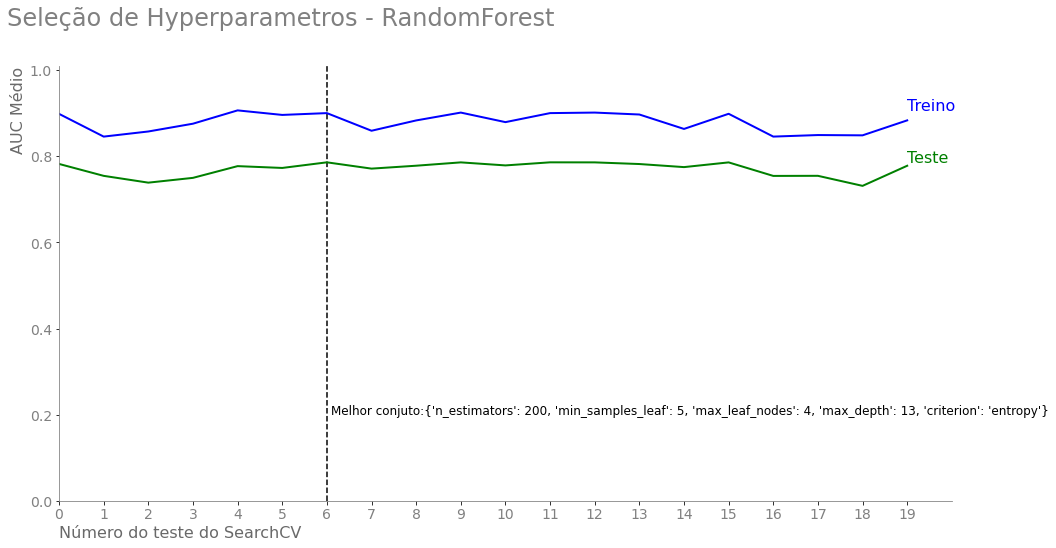

melhores hyperparametros : {'n_estimators': 200, 'min_samples_leaf': 5, 'max_leaf_nodes': 4, 'max_depth': 13, 'criterion': 'entropy'}
Melhor modelo            : RandomForestClassifier(criterion='entropy', max_depth=13, max_leaf_nodes=4,
                       min_samples_leaf=5, n_estimators=200, random_state=0)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'n_estimators': 200, 'min_samples_leaf': 3, '...",0.782360,0.898664,0.057738,0.008851,0.556452,0.053294,0.049914,0.006078,6
1,"{'n_estimators': 50, 'min_samples_leaf': 4, 'm...",0.754697,0.845841,0.055497,0.012643,0.142413,0.011392,0.017930,0.002309,16
2,"{'n_estimators': 10, 'min_samples_leaf': 2, 'm...",0.738901,0.857729,0.054091,0.015517,0.035134,0.004614,0.009533,0.001872,19
3,"{'n_estimators': 10, 'min_samples_leaf': 4, 'm...",0.750022,0.875820,0.056953,0.012911,0.034271,0.000705,0.008895,0.000671,18
4,"{'n_estimators': 50, 'min_samples_leaf': 5, 'm...",0.777261,0.906737,0.053835,0.008188,0.151709,0.019379,0.018710,0.005480,11
5,"{'n_estimators': 50, 'min_samples_leaf': 3, 'm...",0.773051,0.896195,0.054644,0.009829,0.154243,0.013536,0.017890,0.002476,13
6,"{'n_estimators': 200, 'min_samples_leaf': 5, '...",0.786086,0.900408,0.056616,0.009004,0.602740,0.060755,0.051309,0.008187,1
7,"{'n_estimators': 150, 'min_samples_leaf': 4, '...",0.771479,0.859446,0.057722,0.011176,0.419351,0.042032,0.038759,0.005080,14
8,"{'n_estimators': 100, 'min_samples_leaf': 3, '...",0.778230,0.883398,0.058213,0.010704,0.299388,0.037908,0.028568,0.003867,9
9,"{'n_estimators': 200, 'min_samples_leaf': 3, '...",0.785979,0.901638,0.056713,0.008947,0.599883,0.044740,0.050963,0.007815,3


In [35]:
parameters = {'n_estimators'    : [10, 50, 100, 150, 200],
              'max_depth'       : np.arange(1, 21),
              'criterion'       : ['gini', 'entropy'],
              'min_samples_leaf': np.arange(1, 6),
              'max_leaf_nodes'  : np.arange(2, 6)
             }
modelo = RandomForestClassifier(random_state=0)

resultados, melhor_modelo_forest, melhores_hyperparametros  = treina_modelo_randomized_search_cv(modelo,
                                                                                            x_cv,
                                                                                            y_cv,
                                                                                            parameters,
                                                                                            n_splits=n_splits,
                                                                                            n_repeats=n_repeats,
                                                                                            n_iter=n_iter,
                                                                                            seed=14715)

plota_treino_teste_auc('Seleção de Hyperparametros - RandomForest', 
                       resultados['media_teste'],
                       resultados['media_treino'],
                       resultados['rank_test_score'],
                       melhores_hyperparametros)

resultados_treinamento(resultados, melhor_modelo_forest, melhores_hyperparametros, n = 10)

> 

## 4.5) Support Vector Classification.

> Aqui será treinado do modelo **SVC**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros de busca foram
>* kernel        : [linear, poly, rbf, sigmoid]
>* C             : [0, 2]
>* gamma         : [scale, auto]
>* shrinking     : [True , False]

Fitting 50 folds for each of 50 candidates, totalling 2500 fits


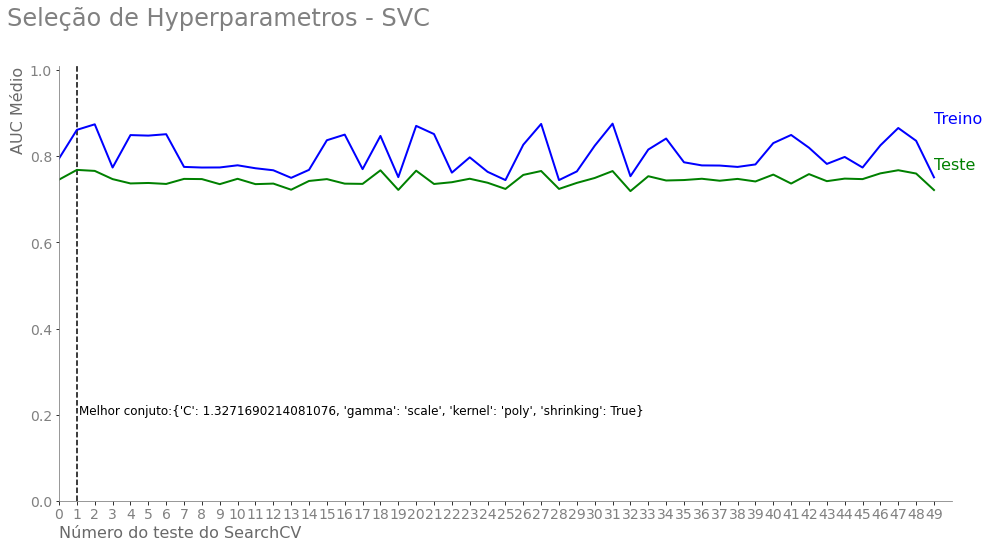

melhores hyperparametros : {'C': 1.3271690214081076, 'gamma': 'scale', 'kernel': 'poly', 'shrinking': True}
Melhor modelo            : SVC(C=1.3271690214081076, kernel='poly', probability=True)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'C': 1.4701863219523719, 'gamma': 'auto', 'ke...",0.745917,0.795059,0.052791,0.011474,0.046113,0.007338,0.010246,0.001864,25
1,"{'C': 1.3271690214081076, 'gamma': 'scale', 'k...",0.768514,0.861532,0.055010,0.009550,0.029410,0.001220,0.007435,0.000852,1
2,"{'C': 1.8813554402370531, 'gamma': 'scale', 'k...",0.766187,0.874382,0.055609,0.009186,0.029551,0.001318,0.007490,0.000927,5
3,"{'C': 0.872565127799168, 'gamma': 'auto', 'ker...",0.747116,0.774037,0.055072,0.011456,0.033076,0.005720,0.007816,0.001124,22
4,"{'C': 1.5194866996222245, 'gamma': 'auto', 'ke...",0.737070,0.849364,0.059737,0.010253,0.039499,0.002787,0.007019,0.000778,36
5,"{'C': 1.375029228314785, 'gamma': 'auto', 'ker...",0.738151,0.848142,0.059791,0.010665,0.031342,0.001561,0.007157,0.000902,35
6,"{'C': 1.7923741955744268, 'gamma': 'scale', 'k...",0.735904,0.851425,0.059942,0.009939,0.042761,0.003175,0.007328,0.000832,41
7,"{'C': 1.206530015269424, 'gamma': 'auto', 'ker...",0.747612,0.775456,0.054842,0.012118,0.031154,0.000738,0.006997,0.000490,19
8,"{'C': 0.010175292060016439, 'gamma': 'scale', ...",0.747161,0.774015,0.055077,0.011469,0.034251,0.004895,0.008028,0.001692,21
9,"{'C': 1.8515891573884744, 'gamma': 'auto', 'ke...",0.735403,0.774183,0.055079,0.011810,0.038279,0.003349,0.009395,0.007267,44


In [47]:
parameters = {'kernel'          : ['linear', 'poly', 'rbf', 'sigmoid'],
              'C'               : uniform(loc=0, scale=2),
              'gamma'           : ['scale', 'auto'],
              'shrinking'       : [True, False]
             }

modelo = SVC(probability=True)

resultados, melhor_modelo_svc, melhores_hyperparametros  = treina_modelo_randomized_search_cv(modelo,
                                                                                            x_cv,
                                                                                            y_cv,
                                                                                            parameters,
                                                                                            n_splits=n_splits,
                                                                                            n_repeats=n_repeats,
                                                                                            n_iter=n_iter,
                                                                                            seed=14715)

plota_treino_teste_auc('Seleção de Hyperparametros - SVC', 
                       resultados['media_teste'],
                       resultados['media_treino'],
                       resultados['rank_test_score'],
                       melhores_hyperparametros)

resultados_treinamento(resultados, melhor_modelo_svc, melhores_hyperparametros, n = 10)

## 4.5) KNeighbors

> Aqui será treinado do modelo **KNeighbor**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros de busca foram
>* n_neighbors   : [1, 10]
>* p             : [1, 2]
>* weights       : [uniform, distance]
>* algorithm     : [auto, ball_tree, kd_tree, brute]

Fitting 50 folds for each of 50 candidates, totalling 2500 fits


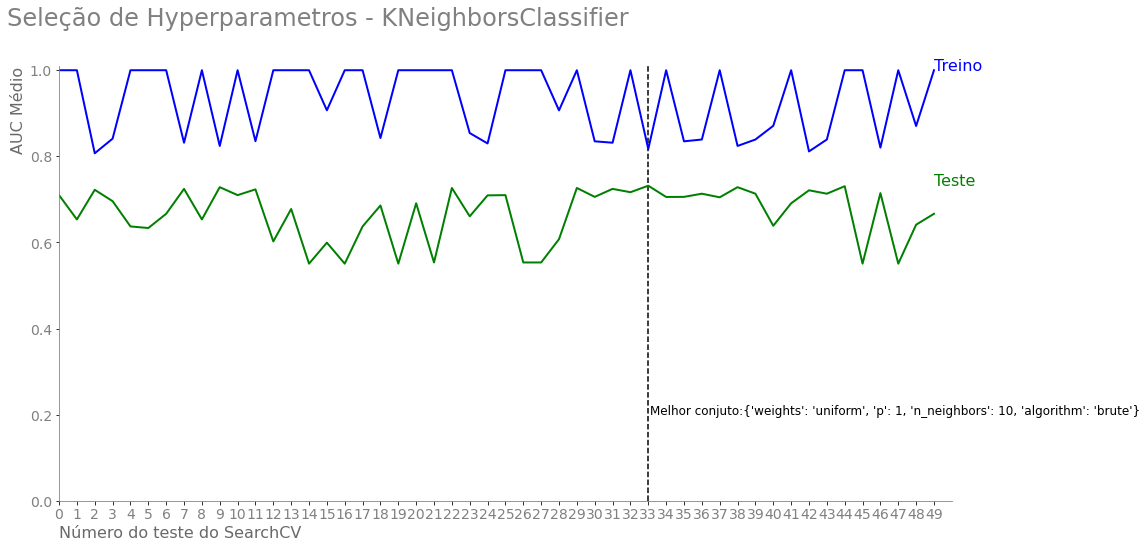

melhores hyperparametros : {'weights': 'uniform', 'p': 1, 'n_neighbors': 10, 'algorithm': 'brute'}
Melhor modelo            : KNeighborsClassifier(algorithm='brute', n_neighbors=10, p=1)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.709900,1.000000,0.058057,0.000000,0.007298,0.004014,0.010316,0.003544,17
1,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.653469,1.000000,0.061130,0.000000,0.005857,0.000849,0.008200,0.000921,33
2,"{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.722271,0.807102,0.060899,0.014816,0.006321,0.001193,0.008468,0.001562,10
3,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.695870,0.841111,0.068274,0.017052,0.006799,0.001366,0.009460,0.001544,25
4,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.637204,1.000000,0.069181,0.000000,0.008852,0.001274,0.011276,0.004758,37
5,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.633538,1.000000,0.060714,0.000000,0.009286,0.001320,0.010521,0.001420,39
6,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.666564,1.000000,0.069889,0.000000,0.007124,0.001512,0.009469,0.001474,30
7,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.724422,0.831628,0.061463,0.014170,0.006869,0.001408,0.009838,0.001696,7
8,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.653469,1.000000,0.061130,0.000000,0.008714,0.001483,0.010409,0.001611,33
9,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.728404,0.824156,0.061109,0.013222,0.009000,0.001447,0.010055,0.001407,3


In [48]:
parameters = {'n_neighbors'     : np.arange(1, 11),
              'p'               : [1, 2],
              'weights'         : ['uniform', 'distance'],
              'algorithm'       : ['auto', 'ball_tree', 'kd_tree', 'brute']
             }

modelo = KNeighborsClassifier()

resultados, melhor_modelo_kn, melhores_hyperparametros  = treina_modelo_randomized_search_cv(modelo,
                                                                                            x_cv,
                                                                                            y_cv,
                                                                                            parameters,
                                                                                            n_splits=n_splits,
                                                                                            n_repeats=n_repeats,
                                                                                            n_iter=n_iter,
                                                                                            seed=14715)

plota_treino_teste_auc('Seleção de Hyperparametros - KNeighborsClassifier', 
                       resultados['media_teste'],
                       resultados['media_treino'],
                       resultados['rank_test_score'],
                       melhores_hyperparametros)

resultados_treinamento(resultados, melhor_modelo_kn, melhores_hyperparametros, n = 10)

# 5) Avaliando o melhor modelo

> Agora vamos avaliar o melhor modelo encontrado utilizando o dados de validação.

In [123]:
modelos = [melhor_modelo_dummy, 
           melhor_modelo_lr, 
           melhor_modelo_arvore, 
           melhor_modelo_forest, 
           melhor_modelo_svc,
           melhor_modelo_kn] 

In [125]:
desempenho_dos_modelos(modelos, x_val, y_val)

,Name,tn,fp,fn,tp,AUC
0,LogisticRegression,25,4,8,16,0.844828


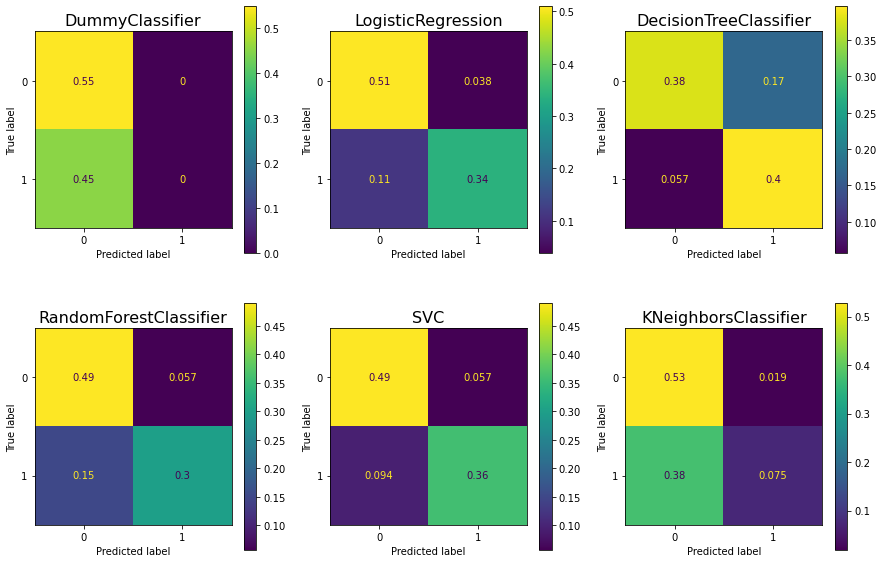

In [83]:
plota_matriz_de_confusao(modelos, x_val, y_val)

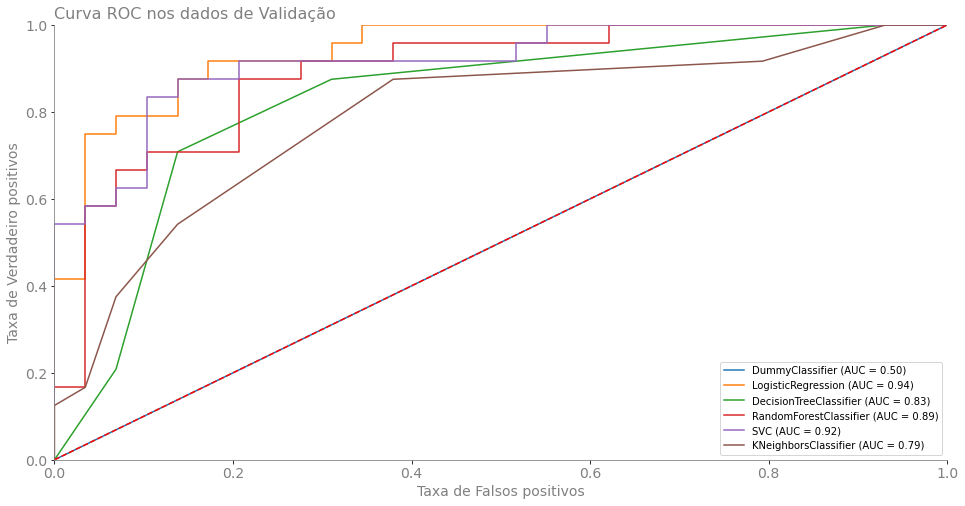

In [88]:
plota_curva_roc(modelos, titulo='Curva ROC nos dados de Validação', x=x_val, y=y_val)

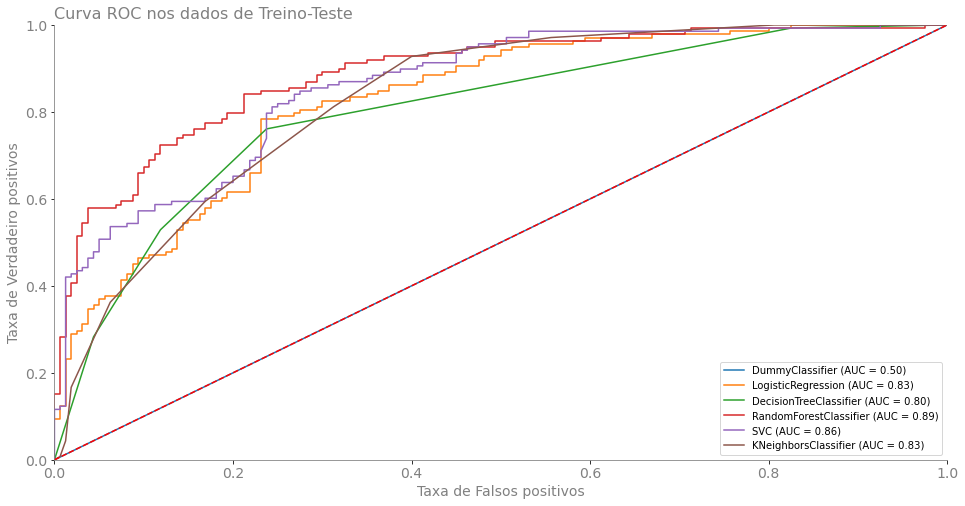

In [80]:
plota_curva_roc(modelos, titulo='Curva ROC nos dados de Treino-Teste', x=x_cv, y=y_cv)